<a href="https://colab.research.google.com/github/bundickm/DS_Unit_2_Water_Pump_Challenge/blob/master/lambda_kaggle_pump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

#Initial Rollercoaster

##Initialization

In [0]:
!pip install category_encoders

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler #necessary?
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from datetime import datetime

pd.options.display.max_columns = 100

In [0]:
def reset():
  test = pd.read_csv('test_features.csv')
  labels = pd.read_csv('train_labels.csv')
  train = pd.read_csv('train_features.csv')
  combine = train.merge(labels)
  
  X_train, X_test, y_train, y_test = train_test_split(
                                     combine.drop('status_group',axis=1), 
                                     combine['status_group'], 
                                     test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test, test

X_train, X_test, y_train, y_test, test = reset()

In [0]:
X_train.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
3607,454,50.0,2013-02-27,Dmdd,2092,DMDD,35.42602,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


##Nulls

In [0]:
#functions for a detailed null report 
from tabulate import tabulate

def list_to_string(list):
  return ', '.join(str(item) for item in list)

def placeholders_present(column,placeholders):
  p_holds = []
  for item in placeholders:
    if len(column.isin([item]).unique())==2:
      p_holds.append(item)
  return list_to_string(list(set(p_holds)))

def null_rec_lookup(null_percent,placeholders=False):
  #Temp Recommendations - Switch to MCAR, MAR, MNAR assessment and recs
  #https://www.youtube.com/watch?v=2gkw2T5jAfo&feature=youtu.be
  #https://stefvanbuuren.name/fimd/sec-MCAR.html
  if placeholders:
    return 'Possible Placeholders: Replace and rerun nulls report.'
  elif null_percent == 100:
    return 'Empty Column: Drop column'
  elif null_percent >= 75:
    return 'Near Empty Column: Create binary feature or drop'
  elif null_percent >= 25:
    return 'Partially Filled Column: Assess manually'
  elif null_percent > 0:
    return 'Mostly Filled Column: Impute values'
  else:
    return ''
  
def nulls(df,placeholders = [-1,-999,-9999,'None','none','missing',
                                   'Missing','Null','null','?']):
  null_count = df.isnull().sum().loc
  total = len(df)
  
  headers = ['Column','Nulls','%Null','Placeholders','Recommendation']
  table = []
  for column in df.columns:
    calc = null_count[column]/total*100
    null_per = str(calc)+'%'
    p_hold = placeholders_present(df[column],placeholders)
    rec = null_rec_lookup(calc,p_hold)
    
    table.append([column,null_count[column],null_per,p_hold,rec])
    
  print(tabulate(table,headers))

In [0]:
nulls(train)

Column                   Nulls  %Null    Placeholders    Recommendation
---------------------  -------  -------  --------------  ------------------------------------------------------
id                           0  0.0%
amount_tsh                   0  0.0%
date_recorded                0  0.0%
funder                       0  0.0%     None            Possible Placeholders: Replace and rerun nulls report.
gps_height                   0  0.0%     -1              Possible Placeholders: Replace and rerun nulls report.
installer                    0  0.0%     None            Possible Placeholders: Replace and rerun nulls report.
longitude                    0  0.0%
latitude                     0  0.0%
wpt_name                     0  0.0%     None            Possible Placeholders: Replace and rerun nulls report.
num_private                  0  0.0%
basin                        0  0.0%
subvillage                   0  0.0%
region                       0  0.0%
region_code                  0  0.0

###installer, funder, permit

In [0]:
#high null correlation between funder, installer, and permit. 
#We'll deal with these together
train[['installer','funder','permit']].isnull().corr()

,installer,funder,permit
installer,1.000000,0.981590,0.705604
funder,0.981590,1.000000,0.709333
permit,0.705604,0.709333,1.000000


In [0]:
#roughly a third of all NaN's have no scheme_name, indicating NaN's may 
#mean no permit which runs counter to the majority of permit values True
(train[train['permit'].isnull()].groupby('scheme_name')['permit'].
 value_counts(dropna=False)).sort_values(ascending=False)[:5]

scheme_name  permit
K            NaN       611
M            NaN       356
I            NaN       195
N            NaN       166
S            NaN       147
Name: permit, dtype: int64

In [0]:
#same with installer
(train[train['installer'].isnull()].groupby('scheme_name')['installer'].
 value_counts(dropna=False)).sort_values(ascending=False)[:5]

In [0]:
#and funder
(train[train['funder'].isnull()].groupby('scheme_name')['funder'].
 value_counts(dropna=False)).sort_values(ascending=False)[:5]

scheme_name  funder
None         NaN       1795
K            NaN        612
M            NaN        356
I            NaN        195
N            NaN        166
Name: funder, dtype: int64

In [0]:
#we look at other features against permit, funder, and installer and see
#a pattern of unknown/none/etc. matching our NaN's indicating these were not
#planned and authorized wells but most likely small local efforts
train.groupby('management')['permit'].value_counts(dropna=False,normalize=True)

management        permit
company           True      0.945985
                  NaN       0.039416
                  False     0.014599
other             True      0.778436
                  NaN       0.118483
                  False     0.103081
other - school    False     1.000000
parastatal        True      0.536199
                  False     0.365950
                  NaN       0.097851
private operator  True      0.528666
                  False     0.431761
                  NaN       0.039574
trust             True      0.602564
                  False     0.384615
                  NaN       0.012821
unknown           True      0.616756
                  False     0.308378
                  NaN       0.074866
vwc               True      0.662478
                  False     0.282939
                  NaN       0.054583
water authority   True      0.827434
                  NaN       0.087389
                  False     0.085177
water board       True      0.880327
             

In [0]:
#Assume the negative value for all three
def fill_nulls(df):
  df = df.copy()
  
  df['funder'] = df['funder'].fillna('None')
  df['installer'] = df['installer'].fillna('None')
  df['permit'] = df['permit'].fillna(False)
  
  return df

###gps_height

In [0]:
#gps height flagged as having a placeholder (-1) but negative altitude is 
#simply below sea level. Given that there are a large number below 0, 
#we can safely assume this is not error but intentional
train[train['gps_height'] < 0]['gps_height'].value_counts().sum()

1496

###subvillage

In [0]:
#most all of the nulls are in two regions but the regions aren't just all 
#null subvillages. Set these nulls to 'Other' in anticipation of consolidating
#and encoding later.
train[train['region'] == 'Mwanza']['subvillage'].value_counts(dropna=False)
train[train['subvillage'].isnull()].groupby('region')['subvillage'].value_counts(dropna=False)

region  subvillage
Dodoma  NaN           361
Mwanza  NaN            10
Name: subvillage, dtype: int64

In [0]:
#add it our fill nulls function
def fill_nulls(df):
  df = df.copy()
  
  df['funder'] = df['funder'].fillna('None')
  df['installer'] = df['installer'].fillna('None')
  df['permit'] = df['permit'].fillna(False)
  train['subvillage'] = train['subvillage'].fillna('Other')
  
  return df

###public_meeting

In [0]:
#Lots of NaN's, don't want to assume value, let's look for a better indicator
train['public_meeting'].value_counts(dropna=False)

True     51011
False     5055
NaN       3334
Name: public_meeting, dtype: int64

In [0]:
p_meet_nulls = (pd.DataFrame(train[train['public_meeting'].isnull()].
                             groupby('region')['public_meeting'].
                             value_counts(dropna=False)))
meet_null_reg = p_meet_nulls.index.get_level_values('region').to_list()

In [0]:
#no region has majority false, likely assign nulls to `True`. 
#Two regions with a large number of nulls though
for meet_reg in meet_null_reg:
  if (train[train['region']==meet_reg]['public_meeting'].
        value_counts(dropna=False,normalize=True)[1] < .5):
    print(meet_reg)
    print(train[train['region']==meet_reg]['public_meeting'].
        value_counts(dropna=False,normalize=True))

In [0]:
#let's see if we can get clarity at subvillage level
#still majority `True`
p_meet_nulls = (pd.DataFrame(train[train['public_meeting'].isnull()].
                             groupby('subvillage')['public_meeting'].
                             value_counts(dropna=False)))
meet_null_reg = p_meet_nulls.index.get_level_values('subvillage').to_list()
for meet_reg in meet_null_reg:
  print(meet_reg)
  print(train[train['subvillage']==meet_reg]['public_meeting'].
        value_counts(dropna=False,normalize=True))

In [0]:
def fill_nulls(df):
  df = df.copy()
  
  df['funder'] = df['funder'].fillna('None')
  df['installer'] = df['installer'].fillna('None')
  df['permit'] = df['permit'].fillna(False)
  train['subvillage'] = train['subvillage'].fillna('Other')
  train['public_meeting'] = train['public_meeting'].fillna(True)
  
  return df

###scheme_name/scheme_management

In [0]:
#majority NaN's (63%) come from unpermitted wells, indicating these may not 
#have an official scheme. A lot of NaN's also exist under `other` for management
#This leads to the assumption that these NaN's have no scheme
scheme_mans = (train[(train['scheme_name'] == 'None') | (train['scheme_name'].
               isnull())].groupby('management')['scheme_name'].
               value_counts(dropna=False).index.
               get_level_values('management').to_list())
for man in scheme_mans:
  print(man)
  print(train[train['management']==man]['scheme_name'].
        value_counts(dropna=False,normalize=True))

In [0]:
#fill in scheme_name with 'None' and replace the 'none' with 'None' too
#scheme_management seems to follow similar logic so we will do the same
def fill_nulls(df):
  df = df.copy()
  
  df['funder'] = df['funder'].fillna('None')
  df['installer'] = df['installer'].fillna('None')
  df['permit'] = df['permit'].fillna(False)
  train['subvillage'] = train['subvillage'].fillna('Other')
  train['public_meeting'] = train['public_meeting'].fillna(True)
  train.loc[train['scheme_name'] == 'none','scheme_name'] = 'None'
  train['scheme_name'] = train['scheme_name'].fillna('None')
  train['scheme_management'] = train['scheme_management'].fillna('None')
  
  return df

###wpt_name

In [0]:
#had two ways to represent `None` so reduce to just `None`
def fill_nulls(df):
  df = df.copy()
  
  df['funder'] = df['funder'].fillna('None')
  df['installer'] = df['installer'].fillna('None')
  df['permit'] = df['permit'].fillna(False)
  df['subvillage'] = df['subvillage'].fillna('Other')
  df['public_meeting'] = df['public_meeting'].fillna(True)
  df.loc[train['scheme_name'] == 'none','scheme_name'] = 'None'
  df['scheme_name'] = df['scheme_name'].fillna('None')
  df['scheme_management'] = df['scheme_management'].fillna('None')
  df.loc[train['wpt_name']=='none','wpt_name'] = 'None'
  
  return df

###Verify

No nulls and all flagged placehoders are addressed/expected

In [0]:
nulls(fill_nulls(train))

Column                   Nulls  %Null    Placeholders    Recommendation
---------------------  -------  -------  --------------  ------------------------------------------------------
id                           0  0.0%
amount_tsh                   0  0.0%
date_recorded                0  0.0%
funder                       0  0.0%     None            Possible Placeholders: Replace and rerun nulls report.
gps_height                   0  0.0%     -1              Possible Placeholders: Replace and rerun nulls report.
installer                    0  0.0%     None            Possible Placeholders: Replace and rerun nulls report.
longitude                    0  0.0%
latitude                     0  0.0%
wpt_name                     0  0.0%     None            Possible Placeholders: Replace and rerun nulls report.
num_private                  0  0.0%
basin                        0  0.0%
subvillage                   0  0.0%
region                       0  0.0%
region_code                  0  0.0

##Fast First

In [0]:
X = fill_nulls(train).select_dtypes(include='number')
y = labels['status_group']

forest = RandomForestClassifier(n_estimators=100, max_depth=15)
forest.fit(X,y)
scores = cross_val_score(forest, X, y, cv=10, 
                         scoring='accuracy', 
                         n_jobs=-1,verbose=10)

scores.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished


0.7102185182724409

In [0]:
y_pred = forest.predict(fill_nulls(test).select_dtypes(include='number'))
# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index
sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('fast_first.csv', index=False)

##Feature Engineering

In [0]:
train.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,None,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [0]:
train['date_recorded'] = pd.to_datetime(train['date_recorded'])

###Numeric Features

In [0]:
def type_and_unique(df,unq_limit=10):
  cols = df.columns
  d_types = list(df.dtypes)
  num_unique = list(df.nunique())
  table = []
  headers=['Column','Type','nUnique','Unique Values']
  
  for i in range(len(df.columns)):
    unique_vals = list_to_string(list(df[cols[i]].unique()[:unq_limit]))
    if (len(list(df[cols[i]].unique())) > unq_limit): 
      unique_vals += '...'

    table.append([cols[i],str(d_types[i]),num_unique[i],unique_vals])
  print(tabulate(table,headers=headers))

type_and_unique(train.select_dtypes(include='number'))

Column             Type       nUnique  Unique Values
-----------------  -------  ---------  ------------------------------------------------------------------------------------------------------------------------------------
id                 int64        59400  69572, 8776, 34310, 67743, 19728, 9944, 19816, 54551, 53934, 46144...
amount_tsh         float64         98  6000.0, 0.0, 25.0, 20.0, 200.0, 500.0, 50.0, 4000.0, 1500.0, 6.0...
gps_height         int64         2428  1390, 1399, 686, 263, 0, 62, 1062, 1368, 1645, 1703...
longitude          float64      57516  34.93809275, 34.6987661, 37.46066446, 38.48616088, 31.13084671, 39.1727956, 33.36240982, 32.62061707, 32.71110001, 30.62699053...
latitude           float64      57517  -9.85632177, -2.14746569, -3.82132853, -11.15529772, -1.82535885, -4.76558728, -3.76636472, -4.22619802, -5.14671181, -1.25705061...
num_private        int64           65  0, 39, 5, 45, 6, 3, 698, 32, 15, 7...
region_code        int64           27  11, 20, 

In [0]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [0]:
X_train[['district_code','subvillage','lga','ward']]

,district_code,subvillage,lga,ward
3607,1,Bashnet Kati,Babati,Bashinet
50870,6,Lukali,Bahi,Lamaiti
20413,6,Chawalikozi,Mbozi,Ndalambo
52806,7,Shuleni,Mbarali,Chimala
50091,1,Ngholong,Kilosa,Chakwale
16521,2,Lumeji,Magu,Sukuma
52225,2,Ngomeni,Maswa,Busilili
9440,3,Namisatu,Kilombero,Kiberege
41885,2,Nyamiselya,Magu,Nyigogo
54042,2,Msebei,Kasulu,Ruhita


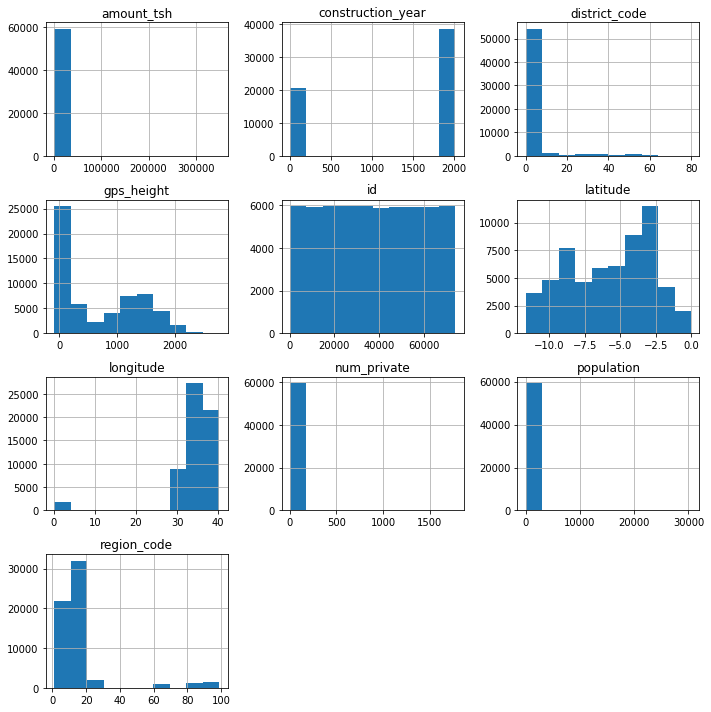

In [0]:
(train.select_dtypes(include='number')).hist(figsize=(10,10))
plt.tight_layout()
plt.show()

In [0]:
train['population'].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

###Categorical Features

In [0]:
#clean up capitalization issues
def lower_case_dataframe(df):
  df = df.copy()

  cols = df.select_dtypes(exclude='number').columns.to_list()
  for col in cols:
    df[col] = df[col].str.lower()
    
  return df

####Duplicate Features

In [0]:
#quite a few categories with identical values
temp = lower_case_dataframe(train.select_dtypes(exclude='number'))
type_and_unique(fill_nulls(temp))

Column                 Type      nUnique  Unique Values
---------------------  ------  ---------  --------------------------------------------------------------------------------------------------------------------------------
date_recorded          object        356  2011-03-14, 2013-03-06, 2013-02-25, 2013-01-28, 2011-07-13, 2011-03-13, 2012-10-01, 2012-10-09, 2012-11-03, 2011-08-03...
funder                 object       1898  roman, grumeti, lottery club, unicef, action in a, mkinga distric coun, dwsp, rwssp, wateraid, isingiro ho...
installer              object       1936  roman, grumeti, world vision, unicef, artisan, dwe, dwsp, water aid, private, danida...
wpt_name               object      37400  None, zahanati, kwa mahundi, zahanati ya nanyumbu, shuleni, tajiri, kwa ngomho, tushirikiane, kwa ramadhan musa, kwapeto...
basin                  object          9  lake nyasa, lake victoria, pangani, ruvuma / southern coast, internal, lake tanganyika, wami / ruvu, rufiji, lake rukwa

In [0]:
def compare_almost_equal(df,feature1,feature2):
  df = pd.DataFrame(df[[feature1,feature2]])
  
  df['is_equal'] = (df[feature1] == df[feature2])
  print(feature1 + ', ' + feature2)
  print(df['is_equal'].value_counts(),'\n')
  
  return df

#let's compare and take note of what we can drop
#drop: waterpoint_type_group, source_type, quantity_group, quality_group, 
#drop: payment, management_group, extraction_type, extraction_type_class
compare_almost_equal(temp,'waterpoint_type','waterpoint_type_group')
compare_almost_equal(temp,'source','source_type')
compare_almost_equal(temp,'quantity','quantity_group') #identical
compare_almost_equal(temp,'water_quality','quality_group')
compare_almost_equal(temp,'payment','payment_type') #identical w/ different name
compare_almost_equal(temp,'management','management_group')
compare_almost_equal(temp,'extraction_type','extraction_type_group')
compare_almost_equal(temp,'extraction_type_group','extraction_type_class')
compare_almost_equal(temp,'funder','installer') #may drop both, need  more info

waterpoint_type, waterpoint_type_group
True     53297
False     6103
Name: is_equal, dtype: int64 

source, source_type
True     37008
False    22392
Name: is_equal, dtype: int64 

quantity, quantity_group
True    59400
Name: is_equal, dtype: int64 

water_quality, quality_group
False    51664
True      7736
Name: is_equal, dtype: int64 

payment, payment_type
True     34559
False    24841
Name: is_equal, dtype: int64 

management, management_group
False    56227
True      3173
Name: is_equal, dtype: int64 

extraction_type, extraction_type_group
True     56931
False     2469
Name: is_equal, dtype: int64 

extraction_type_group, extraction_type_class
True     39957
False    19443
Name: is_equal, dtype: int64 

funder, installer
False    40470
True     18930
Name: is_equal, dtype: int64 



,funder,installer,is_equal
0,roman,roman,True
1,grumeti,grumeti,True
2,lottery club,world vision,False
3,unicef,unicef,True
4,action in a,artisan,False
5,mkinga distric coun,dwe,False
6,dwsp,dwsp,True
7,rwssp,dwe,False
8,wateraid,water aid,False
9,isingiro ho,artisan,False


In [0]:
type_and_unique(drop_features(fill_nulls(temp)))

####High Ordinality

In [0]:
def reduce_ordinality(series,dump_stat='other',ords=20):
  series = series.copy()
  
  values = (series.value_counts(normalize=True)[:ords].index.to_list())
  series.loc[~series.isin(values)] = dump_stat
  
  return series

def mass_ord_reduce(df,features):
  df = df.copy()
  
  for feature in features_dict:
    df[feature] = reduce_ordinality(df[feature],ords = features_dict[feature])
  
  return df

In [0]:
#Look at all high ordinality features, reduce funder and installer.
#Drop: 'ward','subvillage','scheme_name','wpt_name'

# mass_ord_reduce(temp,{'funder':19,'installer':12})

# temp['wpt_name'].value_counts(normalize=True)[:34].sum()
# temp['wpt_name'].value_counts(normalize=True)[:34]

####Misc.

In [0]:
#boolean, leave alone
train['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [0]:
#boolean, leave alone
train['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [0]:
#single value for all, drop
train['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [0]:
temp['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [0]:
temp.loc[temp['source'] == 'unknown','source'] = 'other'
temp.loc[temp['payment_type'] == 'unknown','payment_type'] = 'other'
temp.loc[(temp['management'] == 'unknown') | 
         (temp['management'] == 'other - school') | 
         (temp['management'] == 'trust'),'management'] = 'other'

####Encoding

In [0]:
type_and_unique(drop_features(fill_nulls(temp)))

Column                 Type      nUnique  Unique Values
---------------------  ------  ---------  -------------------------------------------------------------------------------------------------------------------------
date_recorded          object        356  2011-03-14, 2013-03-06, 2013-02-25, 2013-01-28, 2011-07-13, 2011-03-13, 2012-10-01, 2012-10-09, 2012-11-03, 2011-08-03...
funder                 object       1898  roman, grumeti, lottery club, unicef, action in a, mkinga distric coun, dwsp, rwssp, wateraid, isingiro ho...
installer              object       1936  roman, grumeti, world vision, unicef, artisan, dwe, dwsp, water aid, private, danida...
basin                  object          9  lake nyasa, lake victoria, pangani, ruvuma / southern coast, internal, lake tanganyika, wami / ruvu, rufiji, lake rukwa
region                 object         21  iringa, mara, manyara, mtwara, kagera, tanga, shinyanga, tabora, pwani, ruvuma...
lga                    object        125  ludewa

In [0]:
def encode(df):
  df = df.copy()
  
  high_ord_features = ['funder','installer','region',
                       'lga','extraction_type_group']
  low_ord_features = ['basin','management','payment_type','water_quality',
                      'quantity','source','source_class','waterpoint_type']

  ord_encode = ce.OrdinalEncoder()
#   one_hot = ce.OneHotEncoder(cols=low_ord_features,use_cat_names=True)
  
  df = ord_encode.fit_transform(df)
#   df = one_hot.fit_transform(df)
  
  return df

##Verify It

In [0]:
def scaling(df):
  df = df.copy()
  
  scaler = RobustScaler() #look at doing this with MinMaxScaler
  df[['amount_tsh']] = scaler.fit_transform(df[['amount_tsh']])
  df[['population']] = scaler.fit_transform(df[['population']])
  df[['gps_height']] = scaler.fit_transform(df[['gps_height']])
  ###Maybe scale num_private
  
  return df

def time_manipulation(df):
  df = df.copy()
  
  df['date_recorded'] = pd.to_datetime(df['date_recorded'])
  #future proof these calculations for age
  current_year = datetime.now().year
  df['age'] = (current_year - df['construction_year'])
  f_proof = ((df['age'] == current_year) & 
            (df['date_recorded'].dt.year != current_year))
  df.loc[f_proof,'age'] = df[df['age'] < current_year]['age'].median()
  df['age'] = df['age'].astype(int)
    
  return df

def misc_engineering(df):
  df = df.copy()
  
  df['num_private_bool'] = False
  df.loc[df['num_private'] != 0,'num_private_bool'] = True
  df.loc[df['amount_tsh'] == 0,'amount_tsh'] = df['amount_tsh'].median()
  
  return df

def categoricals(df):
  df = df.copy()
  
#   df = lower_case_dataframe(df)
  df = mass_ord_reduce(df,{'funder':19,'installer':12})
  df.loc[df['source'] == 'unknown','source'] = 'other'
  df.loc[df['payment_type'] == 'unknown','payment_type'] = 'other'
  df.loc[(df['management']  == 'unknown') | 
         (df['management']  == 'other - school') | 
         (df['management']  == 'trust'),'management'] = 'other'
  df = encode(df)
  
  return df

def drop_features(df):
  df = df.copy()
  
  features = ['id', 'waterpoint_type_group', 'source_type', 'quantity_group', 
              'quality_group', 'payment', 'management_group', 'extraction_type',
              'extraction_type_class', 'ward', 'subvillage', 'scheme_name',
              'wpt_name', 'scheme_management', 'recorded_by', 'date_recorded', 
              'construction_year','num_private','region','lga','funder',
              'installer','extraction_type_group','management',
              'payment_type','quantity','source','waterpoint_type']
              #num_private?
  
  return df.drop(features,axis='columns')

def feature_engineer(df,scale=False):
  df = df.copy()
  
  df = fill_nulls(df)
  df = misc_engineering(df)
  if scale == True:
    df = scaling(df)
  df = time_manipulation(df)
  df = categoricals(df)
  df = drop_features(df)
  
  return df

In [0]:
X_train, X_test, y_train, y_test, test = reset()
feature_engineer(X_train).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Data columns (total 8 columns):
amount_tsh       47520 non-null float64
gps_height       47520 non-null int64
longitude        47520 non-null float64
latitude         47520 non-null float64
region_code      47520 non-null int64
district_code    47520 non-null int64
population       47520 non-null int64
age              47520 non-null int64
dtypes: float64(3), int64(5)
memory usage: 3.3 MB


In [0]:
X = feature_engineer(X_train)
y = y_train

forest = RandomForestClassifier(max_depth=None,n_estimators=500,
                                n_jobs=-1,min_samples_leaf=5,)
forest.fit(X,y)
scores = cross_val_score(forest, X, y, cv=5,  
                         scoring='accuracy', 
                         n_jobs=-1,verbose=10)

print(scores)
print(scores.mean())
y_pred = forest.predict(feature_engineer(X_test))
accuracy_score(y_test,y_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.5min remaining:   58.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


[0.71638965 0.71930563 0.71009155 0.71387983 0.71724719]
0.7153827679637343


0.7239057239057239

In [0]:
confusion_matrix(y_test,y_pred)

array([[5213,   35, 1209],
       [ 509,  116,  226],
       [1309,   24, 3239]])

In [0]:
X = feature_engineer(X_train,True).select_dtypes(include='number')
y = y_train

xgb = XGBClassifier(max_depth=15,n_estimators=500,
                                n_jobs=-1,min_samples_leaf=2)
xgb.fit(X,y)
scores = cross_val_score(xgb, X, y, cv=5, 
                         scoring='accuracy', 
                         n_jobs=-1,verbose=10)

print(scores)
print(scores.mean())
y_pred = xgb.predict(feature_engineer(X_test,True).select_dtypes(include='number'))
accuracy_score(y_test,y_pred)

#Rewrite

##Feature Engineering

In [0]:
def feature_engineer(df):
  df = df.copy()
  
  ###date and time mods###
  #construction has a year 0 which is extremely unlikely, set 0's to min year-1960
  df.loc[df.construction_year <= 0, df.columns=='construction_year'] = 1960
  #date_recorded isn't datetime so let's fix that and extract year and month
  df['date_recorded'] = pd.to_datetime(df['date_recorded'])
  df['record_year']   = df['date_recorded'].dt.year
  df['record_month']  = df['date_recorded'].dt.month
  #create inspect_wait to measure time from construction to inspection
  df['inspect_wait'] = df['record_year'] - df['construction_year']
  
  ###Categoricals###
  #set all strings to lowercase so we don't have miscounts from capitalization
  cat_cols = train.select_dtypes(exclude='number').columns.tolist()
  cat_cols.remove('date_recorded')
  cat_cols.remove('permit')
  cat_cols.remove('public_meeting')
  df[cat_cols] = lower_case_dataframe(df[cat_cols])
  #reduce the ordinality of the categoricals
  df = mass_ord_reduce(df,cat_cols)
   
  ###Numerics###
#   df['population'] = df['population'].apply(lambda x: np.log(x+1))
  
  #unnecessary features
  drop_features = ['id','waterpoint_type_group','source_type','quantity_group', 
                   'quality_group','payment','management_group',
                   'extraction_type','extraction_type_class','ward','subvillage',
                   'scheme_name','wpt_name','scheme_management','recorded_by',
                   'date_recorded']
  df = df.drop(drop_features,axis='columns')
  
  #encode everything
  encoder = ce.OrdinalEncoder()
  df = encoder.fit_transform(df)
  
  return df

In [0]:
X_train.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
3607,454,50.0,2013-02-27,Dmdd,2092,DMDD,35.42602,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


##Verify It

In [0]:
X_train = feature_engineer(X_train)
X_test  = feature_engineer(X_test)

forest  = RandomForestClassifier(n_estimators=1500, 
                                 min_samples_split=5, 
                                 n_jobs=-1)
forest.fit(X_train,y_train)
scores = cross_val_score(forest, X_train, y_train, cv=5,  
                         scoring='accuracy', 
                         n_jobs=-1,verbose=10)

print(scores)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  6.6min remaining:  4.4min
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.80464969 0.80452393 0.80700831 0.80753446 0.80616647]
0.8059765758822618


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min finished


In [0]:
y_pred = forest.predict(feature_engineer(X_test))
accuracy_score(y_test,y_pred)

0.39015151515151514

#Tabula Rasa

##Import and Load

In [0]:
!pip install eli5

     |████████████████████████████████| 102kB 1.6MB/s 


In [0]:
!pip install category_encoders

     |████████████████████████████████| 92kB 2.3MB/s 


In [0]:
import pandas as pd
import numpy as np
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from eli5.sklearn import PermutationImportance
from eli5 import show_weights

In [0]:
#read in and make sure we can see all columns
pd.set_option('display.max_columns', 100)

X_train = pd.read_csv('train_features.csv')
X_test = pd.read_csv('test_features.csv')
y_train = pd.read_csv('train_labels.csv')

In [0]:
#I've done plenty of EDA by this point so just checking that nothing looks odd
X_train.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


##Fast First

In [0]:
#Run model below and then use permutation importance to drop features
drop_features = ['date_recorded','id','recorded_by','num_private',
                 'management_group','wpt_name','region_code','district_code',
                 'basin','payment','extraction_type_group','source',
                 'source_type']
X_train = X_train.drop(drop_features,axis='columns')
X_test  = X_test.drop(drop_features,axis='columns')

In [0]:
#split X_train to training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=.2)

In [0]:
#encode our categoricals
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

In [0]:
#simple model that I had success with already
forest = RandomForestClassifier(n_jobs=-1, random_state=42)

#Using randomized search cv isn't necessary at this stage but using it to have
#a working option later when I really care about hyperparameter optimization
param_distributions = {'n_estimators':[200],
                       'max_depth':[20]}

search = RandomizedSearchCV(forest, param_distributions=param_distributions,
                            scoring='accuracy', n_iter=20, n_jobs=-1, cv=5,
                            verbose=10, return_train_score=True, random_state=42)
search.fit(X_train, y_train['status_group'])

#Solid score but I have had misleading results, need to test on the validation
print('Training Accuracy Score:',search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.2min remaining:   46.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Training Accuracy Score: 0.8087121212121212


In [0]:
#success! validation works as well
best = search.best_estimator_
X_val = encoder.transform(X_val)
y_pred = best.predict(X_val)
print('Validation Set Accuracy Score:', accuracy_score(y_val['status_group'], y_pred))

Validation Set Accuracy Score: 0.811952861952862


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='accuracy', cv='prefit', 
                                 n_iter=3, random_state=42)

permuter.fit(X_val, y_val['status_group'])

feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0526 ± 0.0010,quantity_group
0.0220 ± 0.0001,extraction_type_class
0.0207 ± 0.0047,quantity
0.0173 ± 0.0026,construction_year
0.0158 ± 0.0010,longitude
0.0140 ± 0.0007,amount_tsh
0.0133 ± 0.0041,waterpoint_type
0.0130 ± 0.0032,latitude
0.0104 ± 0.0005,population
0.0061 ± 0.0020,gps_height


In [0]:
#make predictions for official competition submission
X_test = encoder.transform(X_test)
test_pred = best.predict(X_test)

In [0]:
#submit, jumping from 71% accuracy to 81%
sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = test_pred
submission.to_csv('stripped_down_3.csv', index=False)

##Feature Engineering

In [0]:
#fill in some null values
df['scheme_name'] = df['scheme_name'].fillna('none')
df['public_meeting'] = df['public_meeting'].fillna(True)
df['funder'] = df['funder'].fillna('None')

In [0]:
current_year = datetime.now().year
df['age'] = current_year - df['construction_year']

In [0]:
df['num_private_bool'] = False
df.loc[df['num_private'] != 0,'num_private_bool'] = True

In [0]:
df['lat+lon'] = ((df['latitude']+90)*180)+df['longitude']

In [0]:
#another feature with little impact
df['water_per_person'] = df['amount_tsh']/df['population']
df.loc[df['water_per_person'] == np.inf,'water_per_person'] = np.NaN
df['water_per_person'] = test.fillna(0)

In [0]:
X_train.head(1)
df= X_train.copy()
#look at lat and lon outside of 3 standard deviations, lots of wells at (0,0)
df[(np.abs(df['longitude']-df['longitude'].mean()) > (3*df['longitude'].std()))][['longitude','longitude']]

#fill in the 0's with the average for their regions
df.loc[df['longitude']== 0, 'longitude'] = df.groupby('district_code')['longitude'].transform('mean')
df.loc[df['latitude'] > -.001, 'latitude'] = df.groupby('district_code')['latitude'].transform('mean')

In [0]:
def seasons(months): #Ended up being worse
  #See if we can boost the month signal by consolidating to seasons
  #https://www.wildland.com/destinations/africa/tanzania/seasonsclimate.aspx
  seasons = months.copy()
  
  seasons.loc[(months < 3) | (months == 12)] = 'Hot Dry' #December to February
  seasons.loc[months == 3] = 'Intermittent Rains' #March
  seasons.loc[(months == 4) | (months == 5)] = 'Heavy Rains' #April and May
  seasons.loc[(months > 5) & (months < 11)] = 'Cool Dry' #June to October
  seasons.loc[months == 11] = 'Short Rains' #November
  
  return seasons

In [0]:
from datetime import datetime
#time to add in features to see if we can't improve just a tad
def feature_engineer(df):
  df = df.copy()
  
  #construction has year 0 which is extremely unlikely, set 0's to min year-1960
  df.loc[df.construction_year <= 0, df.columns=='construction_year'] = 1960
  #date_recorded isn't datetime so let's fix that and extract year and month
  df['date_recorded'] = pd.to_datetime(df['date_recorded'])
  #create inspect_wait to measure time from construction to inspection
  df['inspect_wait'] = df['date_recorded'].dt.year - df['construction_year']
  
  #convert all categoricals to lowercase to combine items like 'Other' & 'other'
  cat_features = (df.select_dtypes(exclude='number')
                  .drop(['date_recorded','public_meeting'],axis=1)
                   .columns.to_list())
  for col in cat_features:
    df[col] = df[col].str.lower()
  
  #remove outliers in lat and lon
  df.loc[df['longitude']== 0, 'longitude'] = df.groupby(
                                 'district_code')['longitude'].transform('mean')
  df.loc[df['latitude'] > -.001, 'latitude'] = df.groupby(
                                  'district_code')['latitude'].transform('mean')
  
  #drop the features that are noise/duplicates
  drop_features = ['date_recorded','id','recorded_by','num_private',
                   'management_group','wpt_name','region_code','district_code',
                   'basin','payment','extraction_type_group','source',
                   'source_type','management','water_quality',
                   'waterpoint_type_group','quantity_group', 'subvillage',
                   'extraction_type_class','installer','permit',
                   'scheme_management']
  df = df.drop(drop_features,axis='columns')
  
  return df

In [0]:
#copy down and consolidate cells above
X_train = pd.read_csv('train_features.csv')
X_test  = pd.read_csv('test_features.csv')
y_train = pd.read_csv('train_labels.csv')

#apply our changes, we could do this after the split but saves a few code lines
X_train = feature_engineer(X_train)
X_test  = feature_engineer(X_test)

#split X_train to training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  random_state=42, test_size=.2)

In [0]:
#just copying down some more
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

forest = RandomForestClassifier(n_jobs=-1, random_state=42)

param_distributions = {'n_estimators':[400],
                       'max_depth':[20,23],
                       'min_samples_leaf':[3],
                       'max_features':['sqrt']}

search = RandomizedSearchCV(forest, param_distributions=param_distributions,
                            scoring='accuracy', n_iter=12, n_jobs=-1, cv=5,
                            verbose=10, return_train_score=True, random_state=42)
search.fit(X_train, y_train['status_group'])

print('Training Accuracy Score:',search.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 2 is smaller than n_iter=12. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.9min finished


Training Accuracy Score: 0.803766835016835


In [0]:
results = pd.DataFrame(search.cv_results_)
results.sort_values('rank_test_score').head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,41.307051,0.519456,1.242994,0.066861,400,3,sqrt,20,"{'n_estimators': 400, 'min_samples_leaf': 3, '...",0.802651,0.804208,0.801642,0.808482,0.801852,0.803767,0.002524,1,0.893487,0.893568,0.893232,0.895678,0.893968,0.893987,0.000878


In [0]:
best = search.best_estimator_
X_val = encoder.transform(X_val)
y_pred = best.predict(X_val)
print('Validation Set Accuracy Score:', accuracy_score(y_val['status_group'], 
                                                       y_pred))

Validation Set Accuracy Score: 0.812037037037037


In [0]:
#loop through and drop unnecessary features to refine our model
permuter = PermutationImportance(best, scoring='accuracy', cv='prefit', 
                                 n_iter=3, random_state=42)

permuter.fit(X_val, y_val['status_group'])

feature_names = X_val.columns.tolist()
show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1059 ± 0.0040,quantity
0.0627 ± 0.0041,waterpoint_type
0.0230 ± 0.0023,extraction_type
0.0203 ± 0.0027,amount_tsh
0.0182 ± 0.0012,longitude
0.0156 ± 0.0009,latitude
0.0116 ± 0.0004,lga
0.0097 ± 0.0027,population
0.0087 ± 0.0002,payment_type
0.0087 ± 0.0031,construction_year


In [0]:
#submit
X_test = encoder.transform(X_test)
test_pred = best.predict(X_test)
sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = test_pred
submission.to_csv('new_final_submission_hopefully.csv', index=False)

In [0]:
X_train = encoder.fit_transform(X_train)

xgb = XGBClassifier(n_jobs=-1, random_state=42)

param_distributions = {'n_estimators':[400],
                       'max_depth':[20]
                       'learning_rate':[.1,.01,.001,.0001]}

search = RandomizedSearchCV(xgb, param_distributions=param_distributions,
                            scoring='accuracy', n_iter=4, n_jobs=-1, cv=5,
                            verbose=10, return_train_score=True, random_state=42)
search.fit(X_train, y_train['status_group'])

print('Training Accuracy Score:',search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.2min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.3min finished


Training Accuracy Score: 0.7083543771043771


In [0]:
#success! validation works as well
best = search.best_estimator_
X_val = encoder.transform(X_val)
y_pred = best.predict(X_val)
print('Validation Set Accuracy Score:', accuracy_score(y_val['status_group'], 
                                                       y_pred))

Validation Set Accuracy Score: 0.7111952861952862


#